<a href="https://colab.research.google.com/github/ashikshafi08/Recipe1M/blob/main/Learning_Transformers_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Transformers with TensorFlow 

Here you can find all the theory and code for transformers. 


**What is transformer**

A transformer model handles **variable-sized input using stacks of self-attention layers**.
- Layer outputs can be calculated in parallel, instead of a series like an RNN. 
- Can learn long-range dependencies. 
- Attention mechanism has an infinite reference window 


## Input Embedding 
- Input into the word embedding layer that is the input should be in embedding format. 
- Next we will inject the Positional embeddings, because transformer doesnt have reccurence. The author in the paper used Sine and Cosine function to calculate this. 
    - For every odd time step create a vector using the cosine function. 
    - For every even time step create a vector using the sine funciton. 
    - Then add those vectors and we will get Positional Input Embeddings

## Encoder Layer 
The encoder layer maps all the input sequence into a abstract continous representation that holds the learned info for entire sequence. 

It consists of two sub modules, 
- Multi - headed attention 
- Fully connected layer 
- Also it has residual connections and a Layer Normalization. 

### 1. Multi-Headed Attention 
They use a specific attention mechanism that is called self attention. 

**Self attention** -> helps in associating each individual word in the inputs to other words in a input. Helps to connect. 

To achieve self attention, 
- we connect the inputs into a three distinguished fully connected layers to create the query , key and value vectors. 

[Query, key and values](https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms)
- Query and key form a dot product matrix multiplication to produce a score matrix. The score matrix produces how much focus should be put on each word. 
- Higher the score, the more the focus
- The scores get scaled by dividing with the square root of the queries and the keys. This is for more stable gradients.
- Then the scaled vector is passed into a softmax function to get the probs distribution, this will be our attention weights. 
- So then we multiply the attention weights with our values. The more prob distribution the model will consider it as important words. 
- Then we pass the output vector into a linear layer. 

> Before applying self attention we gotta make sure to split the query , key and value into N vectors, since its a multi-headed (more than 1). And each self attention process is called as a head and its concatenatd into a single vector and then passed into a Linear layer.

So the multi-headed is a module in the transformer network that attends the input and produces an output vector with information on how each word should attend to all other words in a sequence. 

- Then a residual connection that gets connects with the multi-headed output and passed into a LayerNorm. 
- This is again passed into a Point wise Feed Forward network, followed by a LayerNorm layer. 
- Then again a residual connection is been made, where the input of the LayerNorm is passed to the input of the LayerNorm + Feed Forwards output. 


So this whole purpose of this Encoder layer is to make our inputs in a continous representation with a attention detail in it. 

This will make the decoder to focus on the appropriate words in the decoding process. 

> **Note**: We can stack the Encoder layer for N number of times, so at each time it will learn new attention detials. So it helps in predictions. 

## Decoder Layer
The decoder job is to generate the text sequences. Like the encoder the decoder even has the sub layer, 
- 2 multi-headed attention layer 
- point wise fed forward 
- residual connections and LayerNorm after each sub layer. 

The decoder is autoregressive, where it takes the previous outputs as inputs and also the encoder outputs that contains the attention details as inputs. 

Decoder stops when it generates a end token as the output. 

- The input goes into a Embedding layer and Positional Embedding layer and gives out the Positional Embeddings. 
- Then the Positional Embedding is passed into the 1st Multi-head attention layer which computes the attention score for the decoder inputs. 


#### 1st Multi headed attention layer 

**Masking in the decoders multi-head attention**

> **Note**: Since the decoder is auto-regressive and generates the sequence word by word, we need to condition the words from seeing the future tokens. It can have access to the previous tokens but not the upcoming one. 

> To prevent this we use something called a **Mask**, that provides us a with a look ahead mask. So we add the scaled scores and the look ahead mask, this will give us the Masked Scores. 

Mask is the same matrix same as the attention score. And it has negaitve inifinities, so when we take a softmax these -ve infinities will get zero out. So this means zero attention score for the future tokens. 

The output of the first multi-headed attention layer is a mask output vector, which has the information on how the model should attend on the decoders input. 

#### 2nd Multi headed attention layer 
Here we pass two inputs, 
- The output of the Encoder layer, only the queries and the keys.
- Mask output vector of the 1st multi-headed layer, the values. 

This process matches the encoder inputs and the decoder inputs, so it will figure out which input to focus on. 

Likewise the output of the 2nd multi-headed layer passes into point-wise feed forward layer. 

Atlast the output from the point-wise feed forward is passed into a linear classifier layer. Where we specify the various number of classes we have, followed by a softmax layer nnd this will give us the probability distribution. Further computing the argmax we will get the predicted word. 

This goes on and on....






In [1]:
# Some downloads
!pip install tensorflow_datasets
!pip install -U tensorflow-text

     |████████████████████████████████| 4.4 MB 7.7 MB/s 


In [2]:
# Imports 

import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf


logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

### Downloading the datasets 

Testing the transformer on Portuguese-English translation dataset. This dataset contains approx 50000 training examples, 1100 validation examples and 2000 test examples. 



In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete1HGS10/ted_hrlr_translate-train.tfrecord


  0%|          | 0/51785 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete1HGS10/ted_hrlr_translate-validation.tfrecord


  0%|          | 0/1193 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete1HGS10/ted_hrlr_translate-test.tfrecord


  0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [4]:
# Looking into the text examples 
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### Text tokenization & detokenizatiion 

Here we will convert the text to some numeric representation, so now we will convert the text to sequences of token IDs, which are used as indices into an embedding. 

Downloading a saved model 


In [5]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

196608/184801 [===============================] - 0s 1us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [6]:
# Loading the saved model 
tokenizers = tf.saved_model.load(model_name)


The tokenizes contains two text tokenizers, one for english and one for portuguese. 

In [7]:
print([item for item in dir(tokenizers) if not item.startswith('_')])
print([item for item in dir(tokenizers.en) if not item.startswith('_')])
print([item for item in dir(tokenizers.pt) if not item.startswith('_')])

['en', 'graph_debug_info', 'pt', 'signatures', 'tensorflow_git_version', 'tensorflow_version']
['detokenize', 'get_reserved_tokens', 'get_vocab_path', 'get_vocab_size', 'lookup', 'tokenize', 'tokenizer', 'vocab']
['detokenize', 'get_reserved_tokens', 'get_vocab_path', 'get_vocab_size', 'lookup', 'tokenize', 'tokenizer', 'vocab']


- The `tokenize` method converts a batch of strings to a padded-batch of token IDs. 
- This method also splits punctuations, lowercases and unicode-normalizes the input before tokenizing. 

In [8]:
# Printing out the english exampels 
for en in en_examples.numpy():
  print(en.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


The `detokenize` method attempts to convert these token IDs back to human readable text

In [9]:
# Tokenizing a text 
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)


[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [10]:
# Detokenizing a text 
round_trip = tokenizers.en.detokenize(encoded)

for line in round_trip.numpy():
  print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


Lookup method converts from token-IDs to token text

In [11]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability', b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage', b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip', b'##ity', b'.', b'[END]'], [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?', b'[END]'], [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for', b'curiosity', b'.', b'[END]']]>

## Setup input pipeline 

Gotta apply some transformations in order to make the data suitable for Input pipeline. 



In [12]:
# Preprocessing function and we can use while making the dataset
def tokenize_pairs(pt , en):
  '''
  pt -> portugese text
  en -> english text
  '''

  pt = tokenizers.pt.tokenize(pt)

  # Converting the ragged tensors to dense by padding with zero 
  pt = pt.to_tensor()
  return pt , en

In [13]:
# Hyper parameters for batching and shuffling 
BUFFER_SIZE = 20000
BATCH_SIZE = 64 

# Function to apply the dataset transforms 
def make_batches(ds):
  return(
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs , num_parallel_calls = tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE)
  )




In [14]:
# Applying the transforms on our datasets 
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

train_batches , val_batches


(<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.int64, tf.string)>,
 <PrefetchDataset shapes: ((None, None), (None,)), types: (tf.int64, tf.string)>)

### **Positional Encoding** 

- Attention layers see the input as a set of vectors with no sequential order. 
- Like we know the transformers doesnt contain any recurrent or convolutional layers, so this means no reccurence available in the transformers. 

Thats why we need the help of a **positional encoding** and its added to give the mdoel some information about the relatives position of the tokens in the sentence. It kinda filss up the void of reccurence. 

- The positional encoding vector is added to a embedding vector. 
- Since the embedding is a vector and after adding the **positional encoding the tokens will be closer to each  other bases on the similarity of their meaning and their position in the sentence, in the d-dimensional space**. 


So we use two formula's for calculating the positional encoding, 
- Cosine function : For every odd time step create a vector using the cosine function.
- Sine function : For every even time step create a vector using the sine funciton. 
- Then add those vectors and we will get Positional Input Embeddings


In [15]:
# Getting the angles 

def get_angles(pos , i , d_model):
  angle_rates = 1 / np.power(1000 , (2 * (i // 2))) / np.float32(d_model) # 1 / 1000 (to the power 2i / d_model)
  return pos * angle_rates  # here we multiply by pos to make it complete 

# Defining thhe whole positional encoding 
def positional_encoding(position , d_model):
  angle_rads = get_angles(pos = np.arange(position)[: , np.newaxis] , 
                          i = np.arange(d_model)[np.newaxis, :], 
                          d_model = d_model)
  
  # Apply sine function to even indices in the array, 2i 
  angle_rads[: , 0::2] = np.sin(angle_rads[: , 0::2])
  
  # Apply cos to odd indices in the array, 2i+1 
  angle_rads[: , 1::2] = np.cos(angle_rads[: , 1::2])

  # Into one dedicated variable 
  pos_encoding = angle_rads[np.newaxis , ...]
  
  return tf.cast(pos_encoding , dtype = tf.float32)


                 

In [16]:
# Using the above function 
n , d = 2048 , 512 # position and dimension 

# Passing the arguments to our model 
pos_encoding  = positional_encoding(n , d)
pos_encoding = pos_encoding[0]
print(pos_encoding)


tf.Tensor(
[[ 0.0000000e+00  1.0000000e+00  0.0000000e+00 ...            nan
             nan            nan]
 [ 1.9531237e-03  9.9999809e-01  1.9531250e-09 ...            nan
             nan            nan]
 [ 3.9062400e-03  9.9999237e-01  3.9062500e-09 ...            nan
             nan            nan]
 ...
 [-7.5295961e-01 -6.5806675e-01  3.9941406e-06 ...            nan
             nan            nan]
 [-7.5424343e-01 -6.5659487e-01  3.9960937e-06 ...            nan
             nan            nan]
 [-7.5552440e-01 -6.5512049e-01  3.9980469e-06 ...            nan
             nan            nan]], shape=(2048, 512), dtype=float32)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sin
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in cos


In [17]:
pos_encoding[0]

<tf.Tensor: shape=(512,), dtype=float32, numpy=
array([ 0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1., -0.,
        1., -0.,  1.,  0.,  1., -0.,  1.,  0.,  1., nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,

#### Masking
The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

In [18]:
# function to create padding 
def create_padding(seq):
  seq = tf.cast(tf.math.equal(seq , 0) , tf.float32)

  # Add extra dimensions to add the padding (so we can add padding to our attention scores)
  # mask + attention scores 
  return seq[: , tf.newaxis , tf.newaxis , :] # (batch_size , 1 , 1 , seq_len)

In [19]:
# Testing out the above function 
x = tf.constant([  [7 , 6 , 0 , 0 ,1] , [1 , 2 ,3 , 0 , 0] , [0 , 0 , 0 , 4 , 5] ])
create_padding(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future token sequence. In other words, the mask indicates which entries should not be used.

Zero attention scores for the token sequence



In [20]:
# Creating the look ahead matrix 
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones(shape = (size , size)) , -1, 0)
  return mask 

# Applying dummy tensors 
x = tf.random.uniform((1 , 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

### Scaled dot product attention 
Like we saw above the attention function used by the transformer takes namely three inputs, 
- Query (Q)
- Key (K)
- Value (V)

The equation used to calculate the attention weights, 

`Attention(Q , K , V) = Softmax of [ (Query , key)T / square root of the depth of the keys  `

Dont worry much if it take sense, will code every line out and eventually get that shit. 


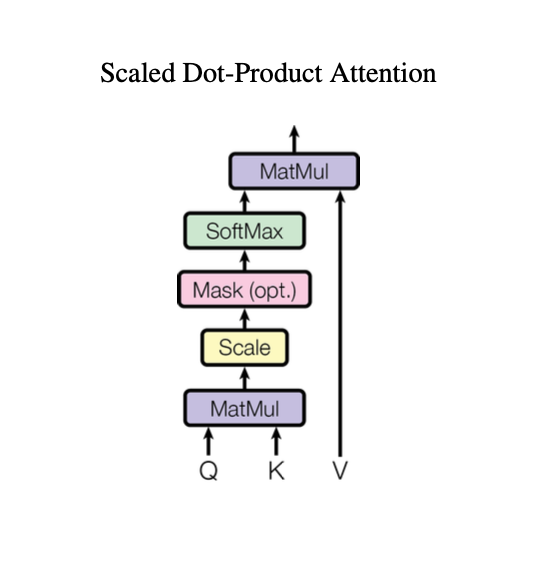

In [21]:
# Function for scaling the dot product attention 

# That is passing in the query , key and value to our attention 
def scaled_out_product_attention(q , k , v , mask):

  '''
  Calculate the attention weights

  - q , k , v must have a matching leading dimensions 
  - k , v must have matching penultimate dimension, i.e seq_len_k = seq_len_v 
  
  The mask has different shapes depending on its type(padding or look ahead) but its broadcastable for attention 


  Args: 
    q: query shape == (..... , seq_len_q , depth)
    key: key shape == (..... , seq_len_q , depth)
    v: value shape == (....., seq_len_v , depth_v)

    mask: Float tensor with shape broadcastable to (.... , seq_len_q , seq_len_k) 

  Returns: 
    output , attention_weights

  '''


  # The first matrix mult for between query and key 
  matmul_qk = tf.matmul(q , k , transpose_b= True) # (... , seq_len_q , seq_len_k)

  # Now scale the above matrix mul output 
  dk = tf.cast(tf.shape(k)[-1] , tf.float32) # getting the last shape index of k, and  casting into float32
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # Adding the mask vector to the scaled tensor 
  if mask is not None: 
    scaled_attention_logits += (mask * -1e-9)

  # Apply softmax 
  # Softmax is normalized on the last axiss (seq_len_k) so that the scores add upto 1 
  attention_weights = tf.nn.softmax(scaled_attention_logits , axis = -1)  # (..., seq_len_q, seq_len_k)

  # Now the matrix multiplication between our values and softmax applied attention weights
  output = tf.matmul(attention_weights , v )

  # It returns the scaled attention weights and the attention_weights
  return output , attention_weights



As the softmax normalization is done on K (keys), its values decide the amount of importance given to Q. 

The output represents the multiplication of the attention weights and the V vector. This ensures that the tokens you want to focus on are kept as-is and the irrelevant tokens are flushed out.

In [22]:
def print_out(q , k , v):

  # Applying the above dot product function
  temp_out , temp_attn = scaled_out_product_attention(q , k , v , None)

  print(f'Attention weights are: {temp_attn}\n')
  print(f'Output is (matmul of v and attention weights): {temp_out}\n')

In [23]:
# Using the above function visualizing our attention weights 
np.set_printoptions(suppress= True)

# Creating the v and k 
temp_k = tf.constant([[10 , 0 , 0] , 
                       [0 , 10 , 0] , 
                       [0 ,0 , 10] , 
                       [0 , 0 , 10]] , dtype = tf.float32) # (4 , 3)

temp_v = tf.constant([[1 , 0], 
                      [10 , 0], 
                      [100 , 5], 
                      [1000 , 6]], dtype = tf.float32) # (4 ,2)


# Creating the query, and its aligned with the second `key`
temp_q = tf.constant([[0 , 10 ,0]] , dtype =tf.float32) # (1, 3)

# Using our print function 
print_out(temp_q , temp_k , temp_v)

Attention weights are: [[0. 1. 0. 0.]]

Output is (matmul of v and attention weights): [[10.  0.]]



### **Multi-Head Attention** 

The multi-head attention consists of four parts, 
- Linear layers 
- Scaled dot-product attention 
- Final linear layer 


**Inputs of multi-head attention block:**
- Each multi head attention block gets three inputs, [Query, Key, Value]. 
- Then these are put through (Dense) layers before the multi-head attention function. 

The (Q , K , V) are passed through seperate linear (Dense) layers for each attention head. And we specified number of heads as `num_heads`  time as outputs. 

**The output shape will be** -> `(batch , num_heads , ....)`

**Scaled dot product attention**
The `scaled_dot_product_attention` function is defined above is applied in a single cell. An appropriate mask must be used in the attention step. 

The *attention output for each head* is then concatenated (using `tf.transpose` and `tf.reshape`) and put through the final `Dense` layer. 


Since its a multi-head attention so we want to get the N number of heads Q , K and V are split into multiple heads because it allows the model to jointly attend to information diferent representation subspaces. 


After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.



**Reading List** 
- https://data-science-blog.com/blog/2021/04/07/multi-head-attention-mechanism/ To know how the multi-head attention works (in and out)




In [24]:
# Coding out the Multi-Head attention!! 


class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self , d_model , num_heads ):
    super(MultiHeadAttention , self).__init__()
    self.num_heads = num_heads 
    self.d_model = d_model # the dimensions 

    assert d_model % self.num_heads == 0 

    self.depth = d_model // self.num_heads

    # Creating our key , value and pairs 
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  
  # A function that will split the head for N number of times 
  def split_heads(self , x , batch_size):

    '''
    Splits the last dimension into (num_heads , depth)
    Transpose the result such that the shape is (batch_size , num_heads , seq_len, depth)
    '''

    x = tf.reshape(x , shape= (batch_size , -1 , self.num_heads , self.depth))
    return tf.transpose(x , perm= [0 , 2 ,1 ,3]) # perm helps us to structure our elements inside the tensor 

  
  # Forward pass 
  def call(self , v , k , q , mask):
    batch_size = tf.shape(q)[0]

    # Getting the k , v and q 
    q = self.wq(q) # (batch_size , seq_len , d_model)
    k = self.wk(k) # (batch_size , seq_len , d_model)
    v = self.wv(v) # (batch_size , seq_len , d_model)


    # Applying spplit heads , depending upon the number of heads 
    q = self.split_heads(q , batch_size) # (batch_size , num_heads , seq_len_q , depth)
    k = self.split_heads(k , batch_size) # (batch_size , num_heads , seq_len_k , depth)
    v = self.split_heads(v , batch_size) # (batch_size , num_heads , seq_len_v , depth)


    # Now we're onto the scaled attention, where we wiill scale our attention weights 
    
    # Lets look at the weigths
    # shape of scaled_attenttion_weights.shape --> (batch_size , num_heads , seq_len_q , depth)
    # shape of attention__weights.shape --> (batch_size , num_heads , seq_len_q , seq_len_k)

    # Getting the scaled attention weights and attention weights value from the function 
    scaled_attention , attention_weights = scaled_out_product_attention(q , k , v , mask)    

    scaled_attention = tf.transpose(scaled_attention , perm = [0 , 2 ,1 ,3]) # (batch_size , seq_len_q , num_heads , depth)

  
    # Now we got the attention weights lets concatenate along the num_heads so we will concatenate all the heads 
    concat_attention = tf.reshape(scaled_attention , shape = (batch_size , -1 , self.d_model)) # (batch_size , seq_len_q , d_model)

    # Atlast putting our concatenated attention into a dense layer 
    output = self.dense(concat_attention) # (batch_size , seq_len_q , d_model)

    # Returning the output(scaled one) and the attention weights 
    return output , attention_weights

Lets create a `MultiHeadAttention` layer to try out, wehre at each location in the sequeunce it runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location. 



In [25]:
# Dummy multi-head attention 
temp_mha = MultiHeadAttention(d_model = 512 , num_heads = 8)

# Dummy input
y = tf.random.uniform((1 , 60 , 512)) # (batch_size , encoder_sequence , d_model)

out , attn = temp_mha(v = y , k = y , q = y , mask = None)
out.shape , attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [26]:
out

<tf.Tensor: shape=(1, 60, 512), dtype=float32, numpy=
array([[[-0.2761638 ,  0.07599244, -1.1748303 , ..., -0.03034562,
         -0.3804115 , -0.12298578],
        [-0.27057928,  0.07503626, -1.169733  , ..., -0.02560627,
         -0.3821526 , -0.12399158],
        [-0.2695321 ,  0.07193279, -1.1785613 , ..., -0.02804965,
         -0.3789319 , -0.12100151],
        ...,
        [-0.27368724,  0.08061019, -1.172421  , ..., -0.02472505,
         -0.37687314, -0.12299362],
        [-0.27594206,  0.08207816, -1.1762881 , ..., -0.02468413,
         -0.3783194 , -0.12467968],
        [-0.2720992 ,  0.07118565, -1.1774892 , ..., -0.02938169,
         -0.3845192 , -0.12178519]]], dtype=float32)>

### Point wise feed forward network 

It consists of two-fully connected layers with a ReLu activation in betwee. 

In [27]:
# Creating a function for point wise forward network 
def point_wise_feed_forward(d_model , dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff , activation= 'relu') ,# (batch_size , seq_len , dff) 
      tf.keras.layers.Dense(d_model) # (batch_size , seq_len , d_model)
  ])


In [28]:
# Applying on a sample data 

sample_ffn = point_wise_feed_forward(512 , 2048) #(dimensions and dff)

# Passing a dummy data 
sample_ffn(tf.random.uniform((64 , 50 , 512))).shape

TensorShape([64, 50, 512])

## Encoder and Decoder 

- The input sentence is passed through `N` encoder layers that generates an output for each token in the sentence. 
- The decoder attends to encoders output and its own input (self-attention) to predict the next word. 

### Encoder Layer 
Encoder layer consists of sublayers:
- Multi-head attention (has padding mask) 
- Point wise feed forward networks. 

Reach of these sublayers has a residula connections within and its followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in neural networks. 

- The output of each sublayer is `LayerNorm(x + Sublayer(x))`. 
- The normalization is done on the `d_model` (dimension) the last axis. 
- There are N encoder layers in the transformer. 

Lets code them!


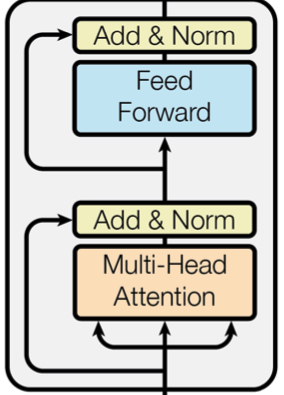

In [29]:
# Building the encoder layer not the whole Encoder itself. 
# This has the whole block of layer except the positional encoding 

class EncoderLayer(tf.keras.layers.Layer):

  def __init__(self , d_model , num_heads , dff , rate = 0.1 ):
    super(EncoderLayer , self).__init__()


    # Defining the sub-layers of the encoder
    self.mha = MultiHeadAttention(d_model , num_heads) # multi head attention 
    self.ffn = point_wise_feed_forward(d_model , dff) # point wise feed forward network 

    # The layer normalization layers (Add & Norm)
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon= 1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon= 1e-6)

    # Defining the dropout layers
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)


  # Initiating the forward pass in the class method 
  def call(self, x , training , mask):

    # At first we pass the input embedding into a multi-head attention (not the positional encoding in here)
    attn_output , _ = self.mha(x , x , x , mask) # (batch_size , input_seq_len , d_model)
    
    # Dropout 
    attn_output = self.dropout1(attn_output , training = training) 

    # Passing inside a layer normalization layer (also initiating the skip connections)
    # We are passing x straight to the attn output (residual connections)
    out1 = self.layernorm1(x + attn_output)  # (batch_size , input_seq_len , d_model)

    # Point wise feed forward network 
    ffn_output = self.ffn(out1) # (batch_size , input_seq_len , d_model)
    
    # Applying dropout 
    ffn_output = self.dropout2(ffn_output , training = training) 

    # Applying layernorm (and initiating the residual connections)
    out2 = self.layernorm2(out1 + ffn_output) # (batch_size , input_seq_len , d_model)

    return out2 


In [30]:
#Passing some dummy data into our Encoder Layer 
sample_encoder_layer = EncoderLayer(d_model = 512 , 
                                    num_heads = 8 , 
                                    dff = 2048)

x = tf.random.uniform((64 , 43 , 512))

sample_enc_layer_output = sample_encoder_layer(x, training = False , mask = None)

sample_enc_layer_output.shape # (batch_size, input_seq_len , d_model)

TensorShape([64, 43, 512])

### Decoder Layer 

Each decoder layer consists of sublayers:
- Masked multi-head attention (with look ahead mask and padding mask) 
- Multi-head attention with padding mask, 
  - where value and key recieve the encoder output as inputs
  - query recieves the output from the masked multi-head attention sublayer. 
- Point wise feed forward networks 

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. 

The normalization is done on the `d_model` last axis. 

Likewise there are N decoder layers in the transformer. 

- As the query recieves the output from decoder's first attention block, and key recieves the encoder output, the **attention weights represent the importance given to the decoders input based on the encoders output.**
- In other words, the decoder predicts the next token by looking at the encoders outputs and self-attending to its own output. 
- 

In [31]:
# Building the Decoder layer 

class DecoderLayer(tf.keras.layers.Layer):

  def __init__(self , d_model , num_heads , dff , rate = 0.1 , **kwargs):
    super(DecoderLayer , self).__init__(**kwargs)

    # Two multi-head attention block in the Decoder 
    self.mha1 = MultiHeadAttention(d_model , num_heads)
    self.mha2 = MultiHeadAttention(d_model , num_heads)

    # Point wise feed forward network 
    self.ffn = point_wise_feed_forward(d_model , dff)

    # Defining the three layer normalization layers 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon= 1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon= 1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon= 1e-6)

    # Dropout layers
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  
  # Initiating the forward pass 
  def call(self , x, enc_output , training , look_ahead_mask , padding_mask):

    # enc_output.shape == (batch_size , input_seq_len , d_model)


    # First multi-head attention and the layer normalization layer
    attn1 , attn_weights_block1 = self.mha1(x , x , x , look_ahead_mask) # (batch_size , target_seq_len , d_model)
    attn1 = self.dropout1(attn1 , training = training)
    out1 = self.layernorm1(attn1 + x)

    # Second multi-head attention, where we will pass the Encoder outputs in here
    # Query and keys --> enc_output 
    # Value --> self attended decoder output
    # Also apply the layer normalization
    attn2 , attn_weights_block2 = self.mha2(
        enc_output , enc_output , out1 , padding_mask ) # (batch_size , target_seq_len , d_model)

    attn2 = self.dropout2(attn2 , training = training)
    out2 = self.layernorm2(attn2 + out1) # (batch_size , target_seq_len , d_model)

    # Point wise feed forward network 
    ffn_output = self.ffn(out2) # (batch_size , target_seq_len , d_model)
    ffn_output = self.dropout3(ffn_output , training = training)
    out3 = self.layernorm3(ffn_output + out1) # (batch_size , target_seq_len , d_model)


    return out3 , attn_weights_block1 , attn_weights_block2  



In [32]:
# Testing out the decoder with sample data 
sample_decoder_layer = DecoderLayer(512 , 8 , 2048)

sample_decoder_layer_output , _ , _ = sample_decoder_layer(
    x = tf.random.uniform((64 , 50 , 512)) , enc_output = sample_enc_layer_output , 
    training = False , look_ahead_mask = None , padding_mask = None
)

sample_decoder_layer_output.shape

TensorShape([64, 50, 512])

So far we've been building the Encoder and Decoder Layers, now its time to build the whole Encoder and Decoder on whole by using the layers we've created. 




## Encoder 
The `Encoder` consists of, 
- Input Embedding 
- Positional Encoding 
- N encoder layers (for n number of times)

- The input is put through an embedding which is summed with the positional encoding. 
- The output of this summation is the input to the encoder layers that we created above `EncoderLayer`. 
- The output of the encoder is the input to the decoder. 



In [33]:
# Coding out the Encoder 

class Encoder(tf.keras.layers.Layer):
  def __init__(self , num_layers , d_model , num_heads , dff , input_vocab_size , 
                maximum_position_encoding , rate = 0.1  ):
    super(Encoder , self).__init__()

    # Getting the dimensions 
    self.d_model = d_model 
    self.num_layers = num_layers # number of layers

    # Initializing a Embedding layer to get the inputs 
    self.embedding = tf.keras.layers.Embedding(input_vocab_size , d_model)
    
    # Defining the positional encoder 
    self.pos_encoding = positional_encoding(maximum_position_encoding , 
                                            self.d_model)
    
    
    # For the N number of layers we are create the the Encoder layer that has multi-head etc.. 
    self.enc_layers = [EncoderLayer(d_model , num_heads , dff , rate) for _ in range(self.num_layers)]

    # Dropout 
    self.dropout = tf.keras.layers.Dropout(rate)

  
  # Initiating the Forward pass 
  def call(self , x , training , mask):

    # Getting the sequence length 
    seq_len = tf.shape(x)[1]
    print(seq_len)

    # Adding embedding and the positional encoding to our input tokens
    x = self.embedding(x) # (batch_size , input_seq_len , d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model , tf.float32))
    x += self.pos_encoding[: , :seq_len , :]

    # Applying the dropout 
    x = self.dropout(x , training = training)

    # Now indexing into the Encoder layers and passing our inputs
    for i in range(self.num_layers):
      x = self.enc_layers[i](x , training , mask)

    return x # (batch_size , input_seq_len , d_model)

In [34]:
# Passing dummy data 
sample_encoder = Encoder(num_layers = 2 , d_model = 512 , num_heads = 8 , 
                         dff = 2048 , input_vocab_size = 8500 , 
                         maximum_position_encoding = 10000)


# Sample input 
temp_input = tf.random.uniform((64 , 206) , dtype = tf.int64 , minval= 0 , maxval= 200)
sample_encoder_output = sample_encoder(temp_input , training = False , mask = None)

print(sample_encoder_output.shape) # (batch_size , input_seq_len , d_model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sin
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in cos


tf.Tensor(206, shape=(), dtype=int32)
(64, 206, 512)


## Decoder 

The `Decoder` consists of,
- Output Embedding 
- Positional Encoding 
- N decoder layers 

- The target is put through an embedding which is summed with the positional encoding. 
- The output of the this summation is the input to the decoder layers.
- The output of the decoder is the input to the final linear layer. 

In [35]:
class Decoder(tf.keras.layers.Layer):

  def __init__(self , num_layers , d_model , num_heads ,dff , target_vocab_size , maximum_position_encoding , rate = 0.1):
    super(Decoder , self).__init__()

    # Get the dimensions and number of layers 
    self.d_model = d_model
    self.num_layers = num_layers

    # Embedding and positional encoding 
    self.embedding = tf.keras.layers.Embedding(target_vocab_size , d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding , d_model)

    # Generating the decoder layers 
    self.dec_layers = [DecoderLayer(d_model , num_heads , dff , rate) for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  
  # Initializing the forward pass 
  def call(self , x , enc_output , training , look_ahead_mask , padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {} 

    x = self.embedding(x) # (batch_size, target_seq_len , d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model , tf.float32))
    x += self.pos_encoding[: , :seq_len , :]

    x = self.dropout(x , training = training)

    for i in range(self.num_layers):
      x , block1 , block2  = self.dec_layers[i](x , enc_output , training , 
                                                look_ahead_mask , padding_mask)
      
      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2 

    # x.shape --> (batch_size , target_seq_len , d_model)
    # also we return attention_weights dictionary
    return x , attention_weights

In [36]:
# Passing the sample data 
sample_decoder = Decoder(2 , 512 , 8 , 2048 , 8000 , 5000)
temp_input = tf.random.uniform((64,  26), dtype = tf.int64 , minval = 0 , maxval = 200)

output , attn = sample_decoder(temp_input , 
                               enc_output = sample_encoder_output  , 
                               training = False , 
                               look_ahead_mask = None , 
                               padding_mask = None)

# Printing the output shape 
output.shape , attn['decoder_layer2_block2'].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sin
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in cos


(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 206]))

Alright we have all the modules and layers required for creating the whole transformer model. Lets put them altogether and create a Model class called Transformer. 

Talking about the masks where encoder takes only one masks whereas decoders takes two of them, 
- Encoder -> Encoder padding mask 
- Decoder -> Decoder padding mask and Look ahead mask 

where the look ahead mask helps to figure out the future tokens. 

In [37]:
# Coding out the entire Transformer class 


class Transformer(tf.keras.Model):
  def __init__(self , num_layers , d_model , num_heads , dff , input_vocab_size , 
               target_vocab_size , pe_input , pe_target , rate = 0.1):
    super().__init__()

    # Initializing the Encoder and the Decoder + The file dense layer 
    self.encoder  = Encoder(num_layers , d_model , num_heads , dff , input_vocab_size , 
                            pe_input , rate)
    

    self.decoder = Decoder(num_layers , d_model , num_heads , dff , input_vocab_size , 
                           pe_input , rate)
    
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)


  # Initializing the forward pass 
  def call(self, inputs , training):

    # Keras model prefer if we pass all the inputs in the first segment 
    # Unpacking 
    inp , tar = inputs 

    # Function to create masks 
    enc_padding_mask  , look_ahead_mask , dec_padding_mask = self.create_masks(inp , tar)

    # Getting the output from the encoder 
    enc_output = self.encoder(inp , training , enc_padding_mask) # (batch_size , inp_seq_len , d_model)

    # Now the decoder (takes in the encoder output , look ahead mask , padding mask and the target)
    # dec_output.shape --> (batch__size , tar_seq_len , d_modek)
    dec_output , attention_weights = self.decoder(tar , enc_output , 
                                                  training , look_ahead_mask , dec_padding_mask)
    
    final_output = self.final_layer(dec_output) # (batch_size , tar_seq_len , target_vocab_size)

    return final_output , attention_weights 

  # Function to create the masks 
  def create_masks(self , inp , tar):

    # Encoder padding mask 
    enc_padding_mask = create_padding(inp)


    # Used in the 2nd attention block in the decoder 
    # This padding mask is used to mask the encoder ouputs 
    dec_padding_mask = create_padding(inp)

    # Using in the 1 st attention block in the decoder 
    # It is used to pad and mask future tokens in the input recieved by the decoder 
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask , look_ahead_mask)

    return enc_padding_mask , look_ahead_mask , dec_padding_mask 



In [40]:
# Testing on the dummy data 
sample_transformer = Transformer(
    num_layers = 2 , d_model = 512 , num_heads = 8 , dff = 2048 , 
    input_vocab_size = 8500 , target_vocab_size = 8000 , 
    pe_input = 10000 , pe_target = 6000
)

# Passing dummy inputs 
temp_input = tf.random.uniform((64 , 38) , dtype = tf.int64 , minval = 0 , maxval = 200 )
temp_targ = tf.random.uniform((64 , 36) , dtype = tf.int64 , minval = 0 , maxval = 200 )

# Using the above Transformer valls 
# Passing in the input and output 
fn_out , _ = sample_transformer([temp_input , temp_targ] , training = False)

fn_out.shape # (batch_size , tar_seq_len , target_vocab_size) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sin
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in cos


tf.Tensor(38, shape=(), dtype=int32)


TensorShape([64, 36, 8000])

### Setting the hyper parameters 

In [42]:
num_layers = 4  
d_model = 128
dff = 512 
num_heads = 8 
dropout_rate = 0.1 

Using the adam optimizer with a custom learning rate scheduler 